In [0]:
#!pip install tensorflow==2.0.0b1

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#     -O /tmp/daily-min-temperatures.csv

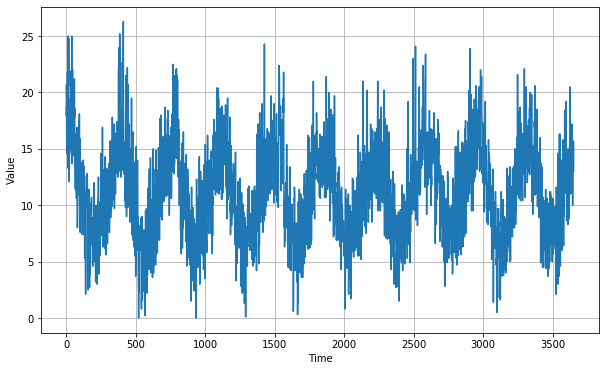

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily_min_temperatures/daily-min-temperatures.csv') as csvfile:
    # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
    # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader=csv.reader(csvfile)
    next(reader)
    for row in reader:
        temps.append(float(row[1]))
    n=len(temps)
    time_step=list(range(1,n+1))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [13]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [45]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [46]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [47]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal',
                          activation='relu', input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 45ms/step - loss: 31.1571 - mae: 31.6550 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 46ms/step - loss: 30.5778 - mae: 31.0756 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 46ms/step - loss: 29.6825 - mae: 30.1801 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 45ms/step - loss: 28.5613 - mae: 29.0586 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 46ms/step - loss: 27.1974 - mae: 27.6945 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 46ms/step - loss: 25.5017 - mae: 25.9986 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 45ms/step - loss: 23.3464 - mae: 23.8429 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 47ms/step - loss: 20.6147 - mae: 21.1108 - l

10/10 [==============================] - 1s 51ms/step - loss: 13.0023 - mae: 13.5005 - lr: 3.5481e-05
Epoch 73/100
10/10 [==============================] - 0s 47ms/step - loss: 12.3223 - mae: 12.8121 - lr: 3.9811e-05
Epoch 74/100
10/10 [==============================] - 0s 44ms/step - loss: 4.1872 - mae: 4.6625 - lr: 4.4668e-05
Epoch 75/100
10/10 [==============================] - 0s 45ms/step - loss: 2.4156 - mae: 2.8776 - lr: 5.0119e-05
Epoch 76/100
10/10 [==============================] - 0s 46ms/step - loss: 3.0043 - mae: 3.4773 - lr: 5.6234e-05
Epoch 77/100
10/10 [==============================] - 1s 59ms/step - loss: 3.6240 - mae: 4.1057 - lr: 6.3096e-05
Epoch 78/100
10/10 [==============================] - 0s 45ms/step - loss: 3.9657 - mae: 4.4504 - lr: 7.0795e-05
Epoch 79/100
10/10 [==============================] - 1s 51ms/step - loss: 4.1181 - mae: 4.6040 - lr: 7.9433e-05
Epoch 80/100
10/10 [==============================] - 1s 50ms/step - loss: 4.1785 - mae: 4.6643 - lr: 8.9

[1e-08, 0.0001, 0, 60]

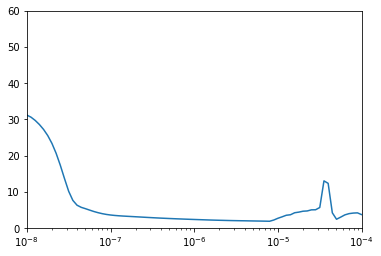

In [48]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 2/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786: 0s - loss: 1.7490 - mae: 2
Epoch 3/50
25/25 [==============================] - 0s 18ms/step - loss: 1.7290 - mae: 2.1786
Epoch 4/50
25/25 [==============================] - 0s 18ms/step - loss: 1.7290 - mae: 2.1786
Epoch 5/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 6/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 7/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 8/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 9/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 10/50
25/25 [==============================] - 0s 19ms/step - loss: 1.7290 - mae: 2.1786
Epoch 11/50
25/25 [============

In [57]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

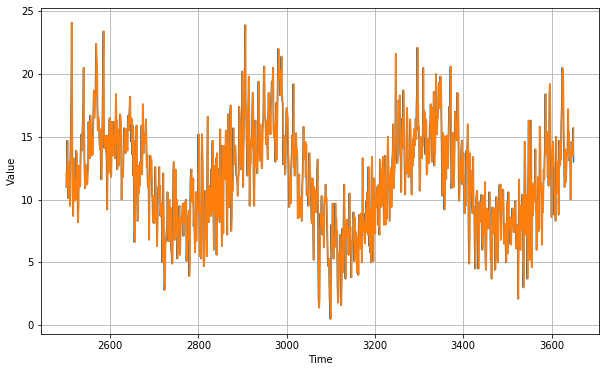

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [59]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

2.0112173913043474

In [60]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.1 11.  12.6 ... 13.6 13.5 15.7]
